In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import re
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('properties_cleaned_v1.csv')

In [3]:
df.duplicated().sum()

np.int64(121)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3785 entries, 0 to 3784
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   property_type    3785 non-null   object 
 1   society          3785 non-null   object 
 2   sector           3785 non-null   object 
 3   price            3785 non-null   float64
 4   price_per_sqft   3785 non-null   float64
 5   area             3785 non-null   float64
 6   areaWithType     3785 non-null   object 
 7   bedRoom          3785 non-null   int64  
 8   bathroom         3785 non-null   int64  
 9   balcony          3785 non-null   object 
 10  additionalRoom   3785 non-null   object 
 11  floorNum         3766 non-null   float64
 12  facing           3785 non-null   object 
 13  agePossession    3784 non-null   object 
 14  nearbyLocations  3609 non-null   object 
 15  furnishDetails   2809 non-null   object 
 16  features         3154 non-null   object 
dtypes: float64(4),

In [5]:
df.sample(5)[['price','area','areaWithType']]

,price,area,areaWithType
1815,0.38,65517.0,Carpet area: 64529 (5994.94 sq.m.)
1266,2.10,1700.0,Super Built up area 1920(178.37 sq.m.)Built Up area: 1800 sq.ft. (167.23 sq.m.)Carpet area: 1700 sq.ft. (157.94 sq.m.)
3322,3.25,2753.0,Super Built up area 2753(255.76 sq.m.)
81,7.50,420.0,Plot area 502(419.74 sq.m.)
855,11.95,255.0,Plot area 305(255.02 sq.m.)


In [6]:
def find_super_built_up(value):
    match = re.search(r'Super Built up area (\d+\.?\d*)',value)
    if match:
        return float(match.group(1))
    return None

In [7]:
df.sample(5)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features
2316,flat,signature global city,sector 37d,0.68,11724.0,580.0,Carpet area: 580 (53.88 sq.m.),2,2,3,others,9.0,not available,0 to 1 Year Old,"['Sapphire 83 Mall Sector 83', 'Dwarka Expressway', 'Pataudi Road', 'NH-8 Delhi Jaipur Highway', 'DPGITM Engineering College Sector 34', 'Genesis Hospital Sector 84', 'Indira Gandhi International Airport', 'Holiday Inn Hotel Sector 90', 'SkyJumper Trampoline Park Gurgaon', 'National Tennis Academy Sector 98']",NaN,"['Power Back-up', 'Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Lift(s)', 'Swimming Pool', 'Maintenance Staff', 'Water Storage', 'Park', 'Visitor Parking', 'Fitness Centre / GYM', 'Club house / Community Center']"
2121,house,independent,sector 7,1.95,13542.0,134.0,Plot area 160(133.78 sq.m.),2,2,2,not available,2.0,not available,10+ Year Old,"['State bank ATM', 'Dr. Madan Clinic', 'Taneja Hospital', 'Dev Man Kathuria Clinic', 'Satyam Hospital Gurgaon', 'Pearl Dental Clinic', 'Chiranjiv Hospital', 'Swastik Maternity and Medical Centre', 'Shiv Mahima Patient Care Bureau', 'Shri Gobind Hospital', 'Navjeevan Hospital and Maternity Centre', 'Ankur Clinic and Maternity Home', 'Lal Superspeciality Hospital', 'Geeta Nursing Home Gurgaon', 'Dr. Ashok Jain', 'Bindal Clinic', 'My Care Clinic', 'M.S Hospital', 'Triveni Hospital Gurgaon', 'Ravi Clinic and Health Care Centre', 'Aryan Hospital', 'Tirath Ram Hospitals Pvt Ltd', 'D.R. Rajnis Gupta Clinic', 'Mangalam Hospital and Heart Centre Gurgaon', 'Sethi Hospital Gurgaon', 'Shubham Hospital Gurgaon', 'Pasricha Hospital and Maternity Home', 'Dr. Ajay S. Gupta Clinic', 'Nangia Hospital Ent and Maternity', 'Sparsh Hospital Gurgaon', 'Rama Hospital & Nursing Home', 'Bhatnagar Maternity and Nursing Home', 'Parashar Hospital', 'Gurgaon Eye Centre', 'Vinayak Hospital Gurgaon', 'Kathuria Hospital', 'Esic Hospital Gurugram', 'Kr Dental Hub', 'Gupta Hospital Gurgaon', 'Dr. Sarvejeet Singh', 'Centre For Sight Gurgaon New Railway Road', 'Kharbanda Maternity and Nursing Home', 'Kidney Clinic', 'State bank of india', 'Hdfc bank', 'Kotak bank', 'Indian bank', 'Pizza Hut', 'St. Michaels Sr. Sec. School', 'Dronacharya Government College']","['5 Fan', '1 Light', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']",NaN
695,flat,orris aster court premier,sector 85,1.73,6757.0,2560.0,Super Built up area 2560(237.83 sq.m.)Built Up area: 2017 sq.ft. (187.39 sq.m.),4,5,3+,servant room,8.0,East,1 to 5 Year Old,"['Propose Metro Station', 'SS Omnia Mall', 'National Highway 8', 'Gurgaon Toll', 'Rajiv Chowk', 'The Heritage Pride Modern School', 'Bharat Ram Global School', 'RPS International School', 'Delhi Public School', 'Matrikiran High School', 'Lions Public School', 'Genesis Hospital', 'Miracles Apollo Cradle / Spectra', 'Silver Streak Multi Speciality', 'IGI Airport']",NaN,"['Swimming Pool', 'Fitness Centre / GYM']"
2422,flat,ireo uptown,sector 66,1.85,12567.0,1472.0,Super Built up area 1472(136.75 sq.m.)Built Up area: 1470 sq.ft. (136.57 sq.m.)Carpet area: 1251 sq.ft. (116.22 sq.m.),2,3,3,"others,servant room",16.0,South-East,1 to 5 Year Old,"['Hub 66', 'Shiksha Bharti Public School', 'VIBGYOR High School', 'Gyan Bharti Public School', 'Diamond Public School', 'Mother land public school', 'Govind Hospital', 'Kamal Hospital', 'HDFC Bank', 'Axis Bank', 'Keshav Pharmacy', 'Apollo Pharmacy', 'Creative Tennis Academy', 'Shanti Tennis Academy', 'Lotus Sports Academy']","['2 Wardrobe', '4 Fan', '1 Exhaust Fan', '3 Geyser', '1 Stove', '12 Light', '4 AC', '1 Modular Kitchen', '1 Chimney', 'No Bed', 'No Curtains', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No TV', 'No Washing Machine',

In [8]:
# This function extracts the Built Up area or Carpet area
def find_area(value, area_type):
    match = re.search(area_type + r'\s*:\s*(\d+\.?\d*)', value)
    if match:
        return float(match.group(1))
    return None

In [9]:
# This function checks if the area is provided in sq.m. and converts it to sqft if needed
def convert_to_sqft(value, area_value):
    if area_value is None:
        return None
    match = re.search(r'{} \((\d+\.?\d*) sq.m.\)'.format(area_value), value)
    if match:
        sq_m_value = float(match.group(1))
        return sq_m_value * 10.7639  # conversion factor from sq.m. to sqft
    return area_value

In [10]:
# Extract Super Built up area and convert to sqft if needed
df['super_built_up_area'] = df['areaWithType'].apply(find_super_built_up)
df['super_built_up_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['super_built_up_area']), axis=1)

# Extract Built Up area and convert to sqft if needed
df['built_up_area'] = df['areaWithType'].apply(lambda x: find_area(x, 'Built Up area'))
df['built_up_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['built_up_area']), axis=1)

# Extract Carpet area and convert to sqft if needed
df['carpet_area'] = df['areaWithType'].apply(lambda x: find_area(x, 'Carpet area'))
df['carpet_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['carpet_area']), axis=1)

In [11]:
df[['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].sample(5)

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
2082,18.50,house,650.0,Plot area 7000(650.32 sq.m.),NaN,NaN,NaN
2560,3.60,house,171.0,Plot area 204(170.57 sq.m.),NaN,NaN,NaN
927,1.69,flat,1848.0,Super Built up area 1845(171.41 sq.m.),1845.0,NaN,NaN
3525,3.45,flat,2872.0,Super Built up area 2872(266.82 sq.m.),2872.0,NaN,NaN
3679,0.65,flat,1153.0,Super Built up area 1153(107.12 sq.m.),1153.0,NaN,NaN


In [12]:
df.duplicated().sum()

np.int64(121)

In [13]:
df[~((df['super_built_up_area'].isnull()) | (df['built_up_area'].isnull()) | (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].shape

(534, 7)

In [14]:
df[df['areaWithType'].str.contains('Plot')][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].head()

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
1,11.50,house,350.0,Plot area 3762(349.5 sq.m.)Built Up area: 9000 sq.ft. (836.13 sq.m.)Carpet area: 6500 sq.ft. (603.87 sq.m.),NaN,9000.0,6500.0
13,3.50,house,180.0,Plot area 215(179.77 sq.m.)Built Up area: 214 sq.yards (178.93 sq.m.)Carpet area: 180 sq.yards (150.5 sq.m.),NaN,214.0,180.0
16,7.20,house,420.0,Plot area 420,NaN,NaN,NaN
25,9.00,house,301.0,Plot area 360(301.01 sq.m.),NaN,NaN,NaN
27,6.95,house,201.0,Plot area 240(200.67 sq.m.)Built Up area: 2160 sq.yards (1806.04 sq.m.)Carpet area: 1720 sq.yards (1438.14 sq.m.),NaN,2160.0,1720.0


In [15]:
df.isnull().sum()

property_type             0
society                   0
sector                    0
price                     0
price_per_sqft            0
area                      0
areaWithType              0
bedRoom                   0
bathroom                  0
balcony                   0
additionalRoom            0
floorNum                 19
facing                    0
agePossession             1
nearbyLocations         176
furnishDetails          976
features                631
super_built_up_area    1870
built_up_area          2603
carpet_area            1844
dtype: int64

In [16]:
all_nan_df = df[((df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']]
all_nan_index = df[((df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].index

In [17]:

# Function to extract plot area from 'areaWithType' column
def extract_plot_area(area_with_type):
    match = re.search(r'Plot area (\d+\.?\d*)', area_with_type)
    return float(match.group(1)) if match else None


all_nan_df['built_up_area'] = all_nan_df['areaWithType'].apply(extract_plot_area)

In [18]:

all_nan_df.head()

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
16,7.20,house,420.0,Plot area 420,NaN,420.0,NaN
25,9.00,house,301.0,Plot area 360(301.01 sq.m.),NaN,360.0,NaN
30,17.00,house,420.0,Plot area 502(419.74 sq.m.),NaN,502.0,NaN
39,3.15,house,144.0,Plot area 172(143.81 sq.m.),NaN,172.0,NaN
47,19.00,house,418.0,Plot area 500(418.06 sq.m.),NaN,500.0,NaN


In [19]:
all_nan_df['built_up_area'].isnull().sum()

np.int64(0)

In [20]:
# all_nan_df.area.astype('float')

In [21]:

def convert_scale(row):
    if round(row['area']/row['built_up_area']) == 9.0:
        return row['built_up_area'] * 9
    elif round(row['area']/row['built_up_area']) == 11.0:
        return row['built_up_area'] * 10.7
    else:
        return row['built_up_area']

all_nan_df['built_up_area'] = all_nan_df.apply(convert_scale,axis=1)

In [22]:
all_nan_df.sample(10)

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
651,9.00,house,251.0,Plot area 300(250.84 sq.m.),NaN,300.0,NaN
3613,0.66,house,51.0,Plot area 550(51.1 sq.m.),NaN,550.0,NaN
30,17.00,house,420.0,Plot area 502(419.74 sq.m.),NaN,502.0,NaN
2193,3.60,house,135.0,Plot area 161(134.62 sq.m.),NaN,161.0,NaN
809,1.30,house,105.0,Plot area 1125(104.52 sq.m.),NaN,1125.0,NaN
1139,9.85,house,350.0,Plot area 418(349.5 sq.m.),NaN,418.0,NaN
3735,4.60,house,161.0,Plot area 192(160.54 sq.m.),NaN,192.0,NaN
2874,8.81,house,301.0,Plot area 360(301.01 sq.m.),NaN,360.0,NaN
1027,3.75,house,15.0,Plot area 160(14.86 sq.m.),NaN,160.0,NaN
1510,3.30,house,161.0,Plot area 192(160.54 sq.m.),NaN,192.0,NaN


In [23]:
all_nan_df.shape

(534, 7)

In [24]:
df.update(all_nan_df)
df.isnull().sum()

property_type             0
society                   0
sector                    0
price                     0
price_per_sqft            0
area                      0
areaWithType              0
bedRoom                   0
bathroom                  0
balcony                   0
additionalRoom            0
floorNum                 19
facing                    0
agePossession             1
nearbyLocations         176
furnishDetails          976
features                631
super_built_up_area    1870
built_up_area          2069
carpet_area            1844
dtype: int64

In [25]:
t = []
for i in df['additionalRoom']:
    t.extend(i.split(","))

room_cats = list(set(t))
room_cats.remove('not available')
room_cats

['servant room', 'store room', 'others', 'study room', 'pooja room']

In [26]:
# Implement ONE HOT ENCODING for additionalrooms

additional_rooms_col = room_cats
for col in additional_rooms_col:
    df[col] = df['additionalRoom'].str.contains(col).astype('int')

df.sample(6)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area,servant room,store room,others,study room,pooja room
3027,house,independent,manesar,2.00,14954.0,124.0,Plot area 1337.4(124.25 sq.m.),3,1,0,not available,3.0,North,5 to 10 Year Old,"['Dr. Sahil Clinic', 'Pooja Clinic', 'Yadav Dental & Eye Care', 'Prakash Hospital', 'Shri Rade Clinic', 'Dental Hospital', 'Petrol pump Maitri motors', 'Petrol Pump', ""McDonald's"", ""McDonald's"", 'Rao Dhaba']",[],"['Private Garden / Terrace', 'Water Storage']",NaN,1337.4,NaN,0,0,0,0,0
349,flat,vatika gurgaon,sector 83,1.25,6313.0,1980.0,Super Built up area 1980(183.95 sq.m.)Built Up area: 1700 sq.ft. (157.94 sq.m.)Carpet area: 1400 sq.ft. (130.06 sq.m.),3,3,2,servant room,12.0,North,5 to 10 Year Old,"['Huda Metro Station (Gurugram)', 'Sapphire 83 Mall', 'Vatika Sector Road', 'Gurgaon - Delhi Expy', 'Dwarka Expy', 'Euro International School, Sec 84', 'DPG Degree College', 'Aarvy Healthcare Super Speciality', 'Indira Gandhi Intl Airport', 'Garhi Harsaru Junction']",NaN,"['Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'No open drainage around', 'Bank Attached Property', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Low Density Society', 'Shopping Centre', 'Fitness Centre / GYM', 'Waste Disposal', 'Rain Water Harvesting', 'Club house / Community Center', 'Water softening plant']",1980.0,1700.0,1400.0,1,0,0,0,0
3404,house,independent,sector 91,3.60,14815.0,226.0,Plot area 270(225.75 sq.m.),4,4,3,not available,2.0,North-East,0 to 1 Year Old,"['Yadav Clinic', 'Bangali Clinic', 'Dr. J. S. Sarkar Clinic', 'Sagar Clinic', 'Promla Clinic', 'Vijay Petrol Pump', 'HP Petrol Pump', 'Essar Petrol Pump', 'Indian Oil', 'Pizza Hut', 'KFC', ""Domino's Pizza""]","['4 Wardrobe', '9 Fan', '1 Exhaust Fan', '3 Geyser', '1 Microwave', '28 Light', '1 Chimney', '1 Modular Kitchen', '4 AC', 'No Bed', 'No Curtains', 'No Dining Table', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']","['Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'Maintenance Staff', 'Water Storage', 'Park', 'Visitor Parking', 'Waste Disposal', 'Rain Water Harvesting']",NaN,270.0,NaN,0,0,0,0,0
433,flat,afnhb jalvayu vihar,sector 30,0.85,12859.0,661.0,Carpet area: 661 (61.41 sq.m.),2,2,1,others,2.0,West,10+ Year Old,"['Icici bank ATM', 'Hdfc ATM', 'Axis bank ATM', 'Citi bank ATM', 'Icici ATM', 'State bank of india ATM', 'Axis bank ATM', 'Hdfc bank ATM', 'State bank of india ATM', 'Axis bank ATM', 'Punjab national bank ATM', 'Shivam Hospital Gurgaon', 'Ahmed Hospital Multi Speciality', 'Kalyani Hospital Gurgaon', 'Centre For Sight Gurgaon Sector 29', 'Dayal Eye & Maternity Centre', 'Nagpal Nursing Home Gurgaon', 'Gardian Pharmacy', 'City Medical', 'Gardian Pharmacy', 'IBP Petrol Pump', 'Hdfc bank', 'State bank of india sbi', 'Standard chartered bank', 'Cafe Coffee Day', '32nd Milestone', 'Bar and restaurant', 'Fast Food', 'Fast food', 'Om Sweets', 'Dhabba', 'Darbar', 'Spaghetti Kitchen & Bar', 'Pizza Hut', 'Tocpao', ""Hops 'N' Brew"", 'Ardor 29', ""Domino's Pizza"", 'ADDA', ""McDonald's"", 'Gung the palace Korean restaurant', 'Zura', 'Walking Street', 'The Oriental Bloom Chinese and Thai', 'Gola Sizzles', 'Beer & Whisky Bar', 'Swagath', 'Salvan Public School', 'Management Development Institute', 'CR Model Public School']","['2 Wardrobe', '4 Fan', '1 Exhaust Fan', '2 Geyser', '10 Light', '1 Chimney', '1 Modular Kitchen', 'No AC', 'No Bed', 'No Curtains', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']","['Feng Shui / Vaastu Compliant', 'Maintenance Staff', 'Water Storage', 'Park', 'Piped-gas', 'Visitor Parking', 'Security Personnel', 'Club house / Community Center'

In [27]:
df['agePossession'].value_counts()

agePossession
1 to 5 Year Old       1669
5 to 10 Year Old       570
0 to 1 Year Old        527
undefined              331
10+ Year Old           309
Under Construction      89
Within 6 months         70
Within 3 months         26
Dec-23                  22
By 2023                 19
By 2024                 17
Dec-24                  16
Mar-24                  14
Oct-24                   8
Jan-24                   8
Aug-23                   7
Jun-24                   7
Dec-25                   7
Nov-23                   5
Sep-23                   4
By 2025                  4
Oct-23                   4
Aug-24                   4
Jul-24                   4
Nov-24                   3
Jan-25                   3
Feb-24                   3
May-24                   3
Jun-27                   2
Dec-26                   2
Oct-25                   2
Mar-25                   2
Jul-27                   2
Sep-25                   2
By 2027                  2
Jul-25                   2
Apr-26        

In [28]:
# Breaking into categories
def categorize_age_possession(value):
    if pd.isna(value):
        return "Undefined"
    if "0 to 1 Year Old" in value or "Within 6 months" in value or "Within 3 months" in value:
        return "New Property"
    if "1 to 5 Year Old" in value:
        return "Relatively New"
    if "5 to 10 Year Old" in value:
        return "Moderately Old"
    if "10+ Year Old" in value:
        return "Old Property"
    if "Under Construction" in value or "By" in value:
        return "Under Construction"
    try:
        # For entries like 'May 2024'
        int(value.split(" ")[-1])
        return "Under Construction"
    except:
        return "Undefined"

df['agePossession'] = df['agePossession'].apply(categorize_age_possession)

In [29]:

df['agePossession'].value_counts()

agePossession
Relatively New        1669
New Property           623
Moderately Old         570
Undefined              483
Old Property           309
Under Construction     131
Name: count, dtype: int64

In [30]:
df.sample(5)[['furnishDetails','features']]

,furnishDetails,features
2757,"['1 Light', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']","['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Park', 'Visitor Parking']"
3266,[],"['Intercom Facility', 'Lift(s)', 'Park', 'Swimming Pool', 'Club house / Community Center', 'Fitness Centre / GYM', 'Rain Water Harvesting', 'Water softening plant']"
999,"['6 Fan', '6 Light', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']","['Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'Water Storage', 'No open drainage around', 'Park', 'Piped-gas', 'Visitor Parking', 'Security Personnel', 'Internet/wi-fi connectivity', 'Waste Disposal', 'Club house / Community Center', 'Rain Water Harvesting']"
2778,"['3 Wardrobe', '1 Water Purifier', '3 Fan', '1 Exhaust Fan', '3 Geyser', '16 Light', '1 Modular Kitchen', '1 Chimney', '1 Curtains', 'No AC', 'No Bed', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine']","['Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Visitor Parking', 'Internet/wi-fi connectivity', 'Low Density Society', 'Fitness Centre / GYM', 'Waste Disposal', 'Rain Water Harvesting']"
3505,NaN,"['Intercom Facility', 'Lift(s)', 'Feng Shui / Vaastu Compliant', 'Piped-gas', 'Security Personnel', 'Maintenance Staff', 'Internet/wi-fi connectivity', 'Swimming Pool', 'Park', 'Club house / Community Center', 'Fitness Centre / GYM', 'Water softening plant', 'Shopping Centre', 'Rain Water Harvesting']"


In [31]:
furnishing_cats = []
for detail in df['furnishDetails'].dropna():
    furnishings = detail.replace('[', '').replace(']', '').replace("'", "").split(', ')
    furnishing_cats.extend(furnishings)
unique_furnishings = list(set(furnishing_cats))
unique_furnishings

['',
 '26 Fan',
 '29 Light',
 '36 Wardrobe',
 '69 Light',
 '38 Light',
 '22 Wardrobe',
 '7 Geyser',
 '3 Microwave',
 '3 Light',
 '62 Light',
 '5 Wardrobe',
 '11 Geyser',
 '15 AC',
 '17 Light',
 '5 Curtains',
 '1 Fan',
 '4 Geyser',
 '21 Wardrobe',
 '21 Light',
 '3 Geyser',
 '14 Geyser',
 '11 Wardrobe',
 '4 TV',
 '7 AC',
 'No AC',
 '6 Fan',
 '1 Sofa',
 '28 Light',
 '5 Bed',
 '48 Light',
 '4 Fan',
 '10 Curtains',
 '13 Geyser',
 '1 Light',
 '20 Fan',
 '10 TV',
 '13 AC',
 'No Dining Table',
 '5 AC',
 '9 Light',
 '2 Chimney',
 '14 TV',
 '12 TV',
 '26 Light',
 '50 Light',
 '6 Geyser',
 '11 Bed',
 '3 TV',
 '3 Chimney',
 '10 Wardrobe',
 '22 Fan',
 '53 Light',
 'No Light',
 'No Exhaust Fan',
 '5 TV',
 '3 Wardrobe',
 '1 Fridge',
 '18 AC',
 '100 Light',
 '4 Bed',
 '24 Wardrobe',
 '14 Fan',
 '16 Light',
 '6 AC',
 '78 Light',
 '8 Wardrobe',
 '10 Light',
 '55 Light',
 '15 Fan',
 '21 Fan',
 '20 Bed',
 '9 Chimney',
 '21 Curtains',
 '3 Bed',
 '13 Wardrobe',
 'No Fridge',
 '101 Light',
 '19 Light',
 '24 

In [32]:
def find_count(details, furnishing):
    if isinstance(details, str):
        if f"No {furnishing}" in details:
            return 0
        pattern = re.compile(rf"(\d+) {furnishing}")
        match = pattern.search(details)
        if match:
            return int(match.group(1))
        elif furnishing in details:
            return 1
    return 0

columns_to_include = list(set([re.sub(r'No |\d+', '', furnishing).strip() for furnishing in unique_furnishings]))
# columns_to_include = list(set(columns_to_include))
columns_to_include = [furnishing for furnishing in columns_to_include if furnishing]  # Remove empty strings

# Create new columns for each unique furnishing and populate with counts
for furnishing in columns_to_include:
    df[furnishing] = df['furnishDetails'].apply(lambda x: find_count(x, furnishing))

# Create the new dataframe with the required columns
furnishings_df = df[['furnishDetails'] + columns_to_include]

In [33]:
furnishings_df.shape

(3785, 19)

In [34]:
furnishings_df.drop(columns=['furnishDetails'],inplace=True)

C:\Users\anush\AppData\Local\Temp\ipykernel_18444\114705885.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  furnishings_df.drop(columns=['furnishDetails'],inplace=True)


In [35]:
# Wewill create a new categorical column from furnishing details which will tell us the degree of furnishing.
# for this purpose we will use K means clustering



D:\Programs\miniconda3\envs\ds\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "D:\Programs\miniconda3\envs\ds\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "D:\Programs\miniconda3\envs\ds\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Programs\miniconda3\envs\ds\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~

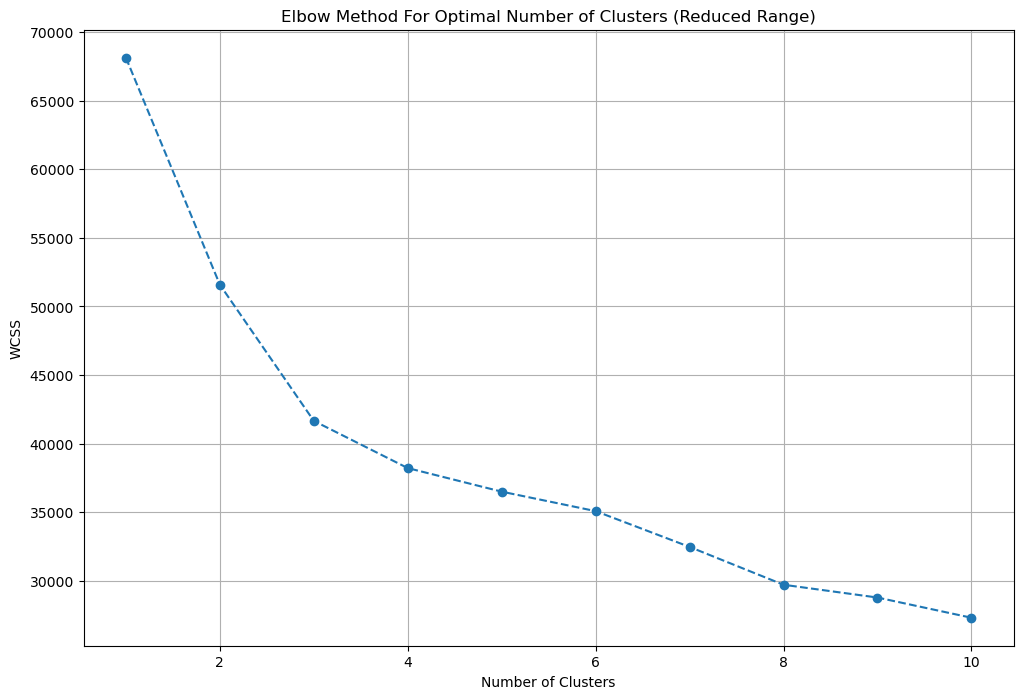

In [36]:
# Scaling the data 

scaler = StandardScaler()
scaled_data = scaler.fit_transform(furnishings_df)

# Using Elbow method to find the exact number of clusters
wcss_reduced = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_data)
    wcss_reduced.append(kmeans.inertia_)

plt.figure(figsize=(12, 8))
plt.plot(range(1,11), wcss_reduced, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters (Reduced Range)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [39]:
# After n = 3 ther is no rapid change in slope, so the cluster could be 3-
# namely 0-> unfurnished 1-> semifurnished 2-> furnishedabs
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(scaled_data)

cluster_assignments = kmeans.predict(scaled_data)

In [43]:
df = df.iloc[:,:-18]
df['furnishing_type'] = cluster_assignments
df.sample(5)[['furnishDetails','furnishing_type']]

,furnishDetails,furnishing_type
2351,"['6 Fan', '2 Geyser', '6 Light', '4 AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']",1
506,"['1 Geyser', '1 Microwave', '6 Light', '6 AC', '1 Modular Kitchen', '1 Chimney', 'No Bed', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']",0
1693,NaN,1
1003,[],1
1082,"['2 Wardrobe', '3 Fan', '1 Exhaust Fan', '2 AC', '1 Modular Kitchen', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Geyser', 'No Light', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']",0


In [50]:
df.loc[df['furnishDetails'].isna(), 'furnishing_type'] = 0

,furnishDetails,furnishing_type
3732,"['1 Light', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']",1
2379,"['1 Light', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']",1
1353,"['3 Wardrobe', '4 Fan', '1 Exhaust Fan', '1 Geyser', '3 Light', '1 Curtains', '1 Chimney', '1 Modular Kitchen', 'No AC', 'No Bed', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']",0
76,"['1 Water Purifier', '1 Light', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine']",1
2067,"['1 Modular Kitchen', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Light', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']",1


In [52]:
df[df['furnishing_type']==1].shape

(1514, 26)

In [53]:
# Features

df[['society','features']].sample(5)

,society,features
1225,breez global heights,"['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Park', 'Visitor Parking']"
1339,puri emerald bay,"['Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Lift(s)', 'Maintenance Staff', 'No open drainage around', 'Visitor Parking', 'Swimming Pool', 'Park', 'Natural Light', 'Internet/wi-fi connectivity', 'Airy Rooms', 'Fitness Centre / GYM', 'Rain Water Harvesting', 'Club house / Community Center']"
6,experion the heartsong,"['Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Recently Renovated', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Internet/wi-fi connectivity', 'Airy Rooms', 'Spacious Interiors', 'Low Density Society', 'Shopping Centre', 'Fitness Centre / GYM', 'Rain Water Harvesting', 'Club house / Community Center']"
2929,hsiidc sidco aravali,"['Lift(s)', 'Maintenance Staff', 'Park', 'Visitor Parking']"
1569,unitech deerwood chase,"['Centrally Air Conditioned', 'Water purifier', 'Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Bank Attached Property', 'Piped-gas', 'Internet/wi-fi connectivity', 'Recently Renovated', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Spacious Interiors', 'Low Density Society', 'Waste Disposal', 'Rain Water Harvesting', 'Fitness Centre / GYM', 'Club house / Community Center']"


In [54]:
df['features'].isnull().sum()

np.int64(631)

In [57]:
# We will find the features deatils for the empty cells from apartments dataframe
temp_df = df[df['features'].isnull()]

In [56]:
df1 = pd.read_csv('apartments.csv')
df1.head()

,PropertyName,PropertySubName,NearbyLocations,LocationAdvantages,Link,PriceDetails,TopFacilities
0,Smartworld One DXP,"2, 3, 4 BHK Apartment in Sector 113, Gurgaon","['Bajghera Road', 'Palam Vihar Halt', 'DPSG Palam Vihar', 'Park Hospital', 'Gurgaon Railway Station']","{'Bajghera Road': '800 Meter', 'Palam Vihar Halt': '2.5 KM', 'DPSG Palam Vihar': '3.1 KM', 'Park Hospital': '3.1 KM', 'Gurgaon Railway Station': '4.9 KM', 'The NorthCap University': '5.4 KM', 'Dwarka Expy': '1.2 KM', 'Hyatt Place Gurgaon Udyog Vihar': '7.7 KM', 'Dwarka Sector 21, Metro Station': '7.2 KM', 'Pacific D21 Mall': '7.4 KM', 'Indira Gandhi International Airport': '14.7 KM', 'Hamoni Golf Camp': '6.2 KM', 'Fun N Food Waterpark': '8.8 KM', 'Accenture DDC5': '9 KM'}",https://www.99acres.com/smartworld-one-dxp-sector-113-gurgaon-npxid-r400415,"{'2 BHK': {'building_type': 'Apartment', 'area_type': 'Carpet Area', 'area': '1,370 sq.ft.', 'price-range': '₹ 2 - 2.4 Cr'}, '3 BHK': {'building_type': 'Apartment', 'area_type': 'Carpet Area', 'area': '1,850 - 2,050 sq.ft.', 'price-range': '₹ 2.25 - 3.59 Cr'}, '4 BHK': {'building_type': 'Apartment', 'area_type': 'Carpet Area', 'area': '2,600 sq.ft.', 'price-range': '₹ 3.24 - 4.56 Cr'}}","['Swimming Pool', 'Salon', 'Restaurant', 'Spa', 'Cafeteria', 'Sun Deck', '24x7 Security', 'Club House', 'Gated Community']"
1,M3M Crown,"3, 4 BHK Apartment in Sector 111, Gurgaon","['DPSG Palam Vihar Gurugram', 'The NorthCap University', 'Park Hospital, Palam Vihar', 'Pacific D21 Mall', 'Palam Vihar Halt Railway Station']","{'DPSG Palam Vihar Gurugram': '1.4 Km', 'The NorthCap University': '4.4 Km', 'Park Hospital, Palam Vihar': '1.4 Km', 'Pacific D21 Mall': '8.2 Km', 'Palam Vihar Halt Railway Station': '1.2 Km', 'Dwarka Sector 21 Metro Station': '8.1 Km', 'Dwarka Expressway': '450 m', 'Fun N Food Water Park': '8.1 Km', 'Indira Gandhi International Airport': '14.1 Km', 'Tau DeviLal Sports Complex': '11.2 Km', 'Hamoni Golf Camp': '5 Km', 'Hyatt Place': '6.1 Km', 'Altrade Business Centre': '11.2 Km'}",https://www.99acres.com/m3m-crown-sector-111-gurgaon-npxid-r404068,"{'3 BHK': {'building_type': 'Apartment', 'area_type': 'Super Built-up Area', 'area': '1,605 - 2,170 sq.ft.', 'price-range': '₹ 2.2 - 3.03 Cr'}, '4 BHK': {'building_type': 'Apartment', 'area_type': 'Super Built-up Area', 'area': '2,248 - 2,670 sq.ft.', 'price-range': '₹ 3.08 - 3.73 Cr'}}","['Bowling Alley', 'Mini Theatre', 'Manicured Garden', 'Swimming Pool', 'Flower Garden', 'Reading Lounge', 'Golf Course', 'Barbecue', 'Sauna']"
2,Adani Brahma Samsara Vilasa,"Land, 3, 4 BHK Independent Floor in Sector 63, Gurgaon","['AIPL Business Club Sector 62', 'Heritage Xperiential Learning School', 'CK Birla Hospital', 'Paras Trinity Mall Sector 63', 'Rapid Metro Station Sector 56']","{'AIPL Business Club Sector 62': '2.7 Km', 'Heritage Xperiential Learning School': '2 Km', 'CK Birla Hospital': '2.5 Km', 'Paras Trinity Mall Sector 63': '3.5 Km', 'Rapid Metro Station Sector 56': '3.8 Km', 'De Adventure Park': '6.8 Km', 'Golf Course Ext Rd': '99 Meter', 'DoubleTree by Hilton Hotel Gurgaon': '3.6 Km', 'KIIT College of Engineering Sohna Road': '8.4 Km', 'Mehrauli-Gurgaon Road': '11.8 Km', 'Indira Gandhi International Airport': '21.1 Km', 'Nirvana Rd': '160 Meter', 'TERI Golf Course': '8.7 Km'}",https://www.99acres.com/adani-brahma-samsara-vilasa-sector-63-gurgaon-npxid-r327995,"{'3 BHK': {'building_type': 'Independent Floor', 'area_type': 'Super Built-up Area', 'area': '1,800 - 3,150 sq.ft.', 'price-range': '₹ 2.43 - 15.75 Cr'}, '4 BHK': {'building_type': 'Independent Floor', 'area_type': 'Super Built-up Area', 'area': '2,750 - 4,500 sq.ft.', 'price-range': '₹ 3.36 - 22.5 Cr'}, 'Land': {'building_type': '', 'area_type': 'Plot Area', 'area': '500 - 4,329 sq.ft.', 'price-range': '₹ 2.05 - 41.13 Cr'}}","['Terrace Garden', 'Gazebo', 'Fountain', 'Amphitheatre', 'Party Lawn', 'Basketball Court', 'Badminton Court', 'Yoga/Meditation Area', 'Indoor Games']"
3,Sobha City,"2, 3, 4 BHK Apartment in S

In [58]:
df1['PropertyName'] = df1['PropertyName'].str.lower()
# Merging temp_df(empty features) with the apartments df so that we can fetch values from the latter one
x = temp_df.merge(df1,left_on='society',right_on='PropertyName',how='left')['TopFacilities']
df.loc[temp_df.index,'features'] = x.values

In [59]:

df['features'].isnull().sum()

np.int64(498)

In [60]:
from sklearn.preprocessing import MultiLabelBinarizer
import ast

In [61]:
# Convert the string representation of lists in the 'features' column to actual lists
df['features_list'] = df['features'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) and x.startswith('[') else [])

# Use MultiLabelBinarizer to convert the features list into a binary matrix
mlb = MultiLabelBinarizer()
features_binary_matrix = mlb.fit_transform(df['features_list'])

# Convert the binary matrix into a DataFrame
features_binary_df = pd.DataFrame(features_binary_matrix, columns=mlb.classes_)

In [62]:
features_binary_df.sample(5)

,24/7 Power Backup,24/7 Water Supply,24x7 Security,ATM,Aerobics Centre,Airy Rooms,Amphitheatre,Badminton Court,Bank Attached Property,Banquet Hall,Bar/Chill-Out Lounge,Barbecue,Basketball Court,Billiards,Bus Shelter,Business Lounge,CCTV Camera Security,Cafeteria,Car Parking,Card Room,Centrally Air Conditioned,Changing Area,Children's Play Area,Cigar Lounge,Clinic,Club House,Club house / Community Center,Community Hall,Concierge Service,Conference room,Creche/Day care,Cricket Pitch,Doctor on Call,Earthquake Resistant,Entrance Lobby,False Ceiling Lighting,Feng Shui / Vaastu Compliant,Fire Fighting Systems,Fitness Centre / GYM,Flower Garden,Food Court,Foosball,Football,Fountain,Gated Community,Gazebo,Golf Course,Grocery Shop,Gymnasium,High Ceiling Height,High Speed Elevators,Infinity Pool,Intercom Facility,Internal Street Lights,Internet/wi-fi connectivity,Jacuzzi,Jogging Track,Landscape Garden,Laundry,Lawn Tennis Court,Library,Lift(s),Lounge,Low Density Society,Maintenance Staff,Manicured Garden,Medical Centre,Milk Booth,Mini Theatre,Multipurpose Court,Multipurpose Hall,Natural Light,Natural Pond,No open drainage around,Park,Pergola,Piped Gas,Piped-gas,Pool Table,Power Back up Lift,Power Back-up,Private Garden / Terrace,Property Staff,RO System,Rain Water Harvesting,Reading Lounge,Recently Renovated,Reflexology Park,Restaurant,Salon,Sauna,School,Security / Fire Alarm,Security Personnel,Separate entry for servant room,Sewage Treatment Plant,Shopping Centre,Skating Rink,Solar Lighting,Solar Water Heating,Spa,Spacious Interiors,Squash Court,Steam Room,Sun Deck,Swimming Pool,Temple,Terrace Garden,Toddler Pool,Valet Parking,Video Door Security,Visitor Parking,Visitors Parking,Volley Ball Court,Waiting Lounge,Waste Disposal,Water Softener Plant,Water Storage,Water purifier,Water softening plant,Wi-Fi Connectivity,Yoga/Meditation Area
1789,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
413,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
1321,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3748,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1557,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0


In [64]:
# Let us calculate a luxury score from the features binary matrix.
# It will be a weighted sum of all the available facilities

# Define the weights for each feature as provided
# Assigning weights based on perceived luxury contribution
weights = {
    '24/7 Power Backup': 8,
    '24/7 Water Supply': 4,
    '24x7 Security': 7,
    'ATM': 4,
    'Aerobics Centre': 6,
    'Airy Rooms': 8,
    'Amphitheatre': 7,
    'Badminton Court': 7,
    'Banquet Hall': 8,
    'Bar/Chill-Out Lounge': 9,
    'Barbecue': 7,
    'Basketball Court': 7,
    'Billiards': 7,
    # 'Bowling Alley': 8,
    'Business Lounge': 9,
    'CCTV Camera Security': 8,
    'Cafeteria': 6,
    'Car Parking': 6,
    'Card Room': 6,
    'Centrally Air Conditioned': 9,
    'Changing Area': 6,
    "Children's Play Area": 7,
    'Cigar Lounge': 9,
    'Clinic': 5,
    'Club House': 9,
    'Concierge Service': 9,
    'Conference room': 8,
    'Creche/Day care': 7,
    'Cricket Pitch': 7,
    'Doctor on Call': 6,
    'Earthquake Resistant': 5,
    'Entrance Lobby': 7,
    'False Ceiling Lighting': 6,
    'Feng Shui / Vaastu Compliant': 5,
    'Fire Fighting Systems': 8,
    'Fitness Centre / GYM': 8,
    'Flower Garden': 7,
    'Food Court': 6,
    'Foosball': 5,
    'Football': 7,
    'Fountain': 7,
    'Gated Community': 7,
    'Golf Course': 10,
    'Grocery Shop': 6,
    'Gymnasium': 8,
    'High Ceiling Height': 8,
    'High Speed Elevators': 8,
    'Infinity Pool': 9,
    'Intercom Facility': 7,
    'Internal Street Lights': 6,
    'Internet/wi-fi connectivity': 7,
    'Jacuzzi': 9,
    'Jogging Track': 7,
    'Landscape Garden': 8,
    'Laundry': 6,
    'Lawn Tennis Court': 8,
    'Library': 8,
    'Lounge': 8,
    'Low Density Society': 7,
    'Maintenance Staff': 6,
    'Manicured Garden': 7,
    'Medical Centre': 5,
    'Milk Booth': 4,
    'Mini Theatre': 9,
    'Multipurpose Court': 7,
    'Multipurpose Hall': 7,
    'Natural Light': 8,
    'Natural Pond': 7,
    'Park': 8,
    # 'Party Lawn': 8,
    'Piped Gas': 7,
    'Pool Table': 7,
    'Power Back up Lift': 8,
    'Private Garden / Terrace': 9,
    'Property Staff': 7,
    'RO System': 7,
    'Rain Water Harvesting': 7,
    'Reading Lounge': 8,
    'Restaurant': 8,
    'Salon': 8,
    'Sauna': 9,
    'Security / Fire Alarm': 9,
    'Security Personnel': 9,
    'Separate entry for servant room': 8,
    'Sewage Treatment Plant': 6,
    'Shopping Centre': 7,
    'Skating Rink': 7,
    'Solar Lighting': 6,
    'Solar Water Heating': 7,
    'Spa': 9,
    'Spacious Interiors': 9,
    'Squash Court': 8,
    'Steam Room': 9,
    'Sun Deck': 8,
    'Swimming Pool': 8,
    'Temple': 5,
    # 'Theatre': 9,
    'Toddler Pool': 7,
    'Valet Parking': 9,
    'Video Door Security': 9,
    'Visitor Parking': 7,
    'Water Softener Plant': 7,
    'Water Storage': 7,
    'Water purifier': 7,
    'Yoga/Meditation Area': 7
}
# Calculate luxury score for each row
luxury_score = features_binary_df[list(weights.keys())].multiply(list(weights.values())).sum(axis=1)

In [65]:

df['luxury_score'] = luxury_score

In [66]:
df.drop(columns=['nearbyLocations','furnishDetails','features','features_list','additionalRoom'],inplace=True)

In [67]:
df.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,super_built_up_area,built_up_area,carpet_area,servant room,store room,others,study room,pooja room,furnishing_type,luxury_score
0,flat,sobha smriti apartments,sector 56,0.50,8333.0,600.0,Carpet area: 600 (55.74 sq.m.),1,1,2,3.0,not available,Undefined,NaN,NaN,600.0,0,0,0,0,0,1,0
1,house,ansal sushant lok plots,sector 43,11.50,17692.0,350.0,Plot area 3762(349.5 sq.m.)Built Up area: 9000 sq.ft. (836.13 sq.m.)Carpet area: 6500 sq.ft. (603.87 sq.m.),7,8,3+,3.0,not available,Old Property,NaN,9000.0,6500.0,1,1,0,0,1,0,31
2,flat,ss the leaf,sector 85,1.20,12371.0,970.0,Super Built up area 1671(155.24 sq.m.)Built Up area: 1190 sq.ft. (110.55 sq.m.)Carpet area: 970 sq.ft. (90.12 sq.m.),2,2,2,4.0,East,Relatively New,1671.0,1190.0,970.0,1,1,0,0,0,1,81
3,flat,dlf regency park,sector 28,2.35,13224.0,1777.0,Super Built up area 1777(165.09 sq.m.)Built Up area: 1700 sq.ft. (157.94 sq.m.)Carpet area: 1600 sq.ft. (148.64 sq.m.),3,4,3,8.0,South-East,Old Property,1777.0,1700.0,1600.0,1,0,0,0,0,0,109
4,flat,dlf the primus,sector 82a,2.20,10516.0,2092.0,Super Built up area 2092(194.35 sq.m.),3,3,3+,16.0,North-East,Relatively New,2092.0,NaN,NaN,1,0,0,0,0,2,174


In [68]:
df.shape

(3785, 23)